## Installs
Although the NiPype tutorial docker container is very well constructed, some python packages are missing.

In [2]:
pip install dipy plotly

     |████████████████████████████████| 8.1 MB 566 kB/s 
     |████████████████████████████████| 11.5 MB 3.8 MB/s 
     |████████████████████████████████| 2.9 MB 4.7 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11430 sha256=26e0c90ade4a335406c06cea512493f5918aa1b92616f1eafb6362f7782fd593
  Stored in directory: /home/neuro/.cache/pip/wheels/ac/cb/8a/b27bf6323e2f4c462dcbf77d70b7c5e7868a7fbe12871770cf
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


bash: line 1: sudo: command not found


CalledProcessError: Command 'b'sudo apt install fsl\n'' returned non-zero exit status 127.

## Imports

In [52]:
from nipype import Workflow, Node, MapNode
from nipype.interfaces.io import DataSink, SelectFiles
from nipype.interfaces.fsl import BET, Eddy, ExtractROI
from nipype.interfaces.utility import Function, IdentityInterface

from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
from dipy.reconst.dti import mean_diffusivity, fractional_anisotropy, TensorModel

from bids.layout import BIDSLayout
import json
import nibabel as nib
import numpy as np
from os.path import join as opj
from IPython.display import Image
import plotly.graph_objects as go

## Variables

In [40]:
experiment_dir = 'output'
output_dir = 'datasink'
working_dir = 'workingdir'

#layout = BIDSLayout('/data/SANE01/Nifti')
data = '/c/Users/ducda/Documents/data/SANE01/Nifti/'

subject_list = ['6001']

## Define DiPy Function

In [46]:
# Define DiPy function
def ReconstMaps(bvals, bvecs, dwi, mask):
    # Define variables
    gtab = gradient_table(bvals, bvecs)    
    data_img = nib.load(DWI)
    data = data_img.get_data()             
    affine = data_img.affine
    mask_img = nib.load(mask)
    mask=mask_img.get_data()

    # Generate FA + ADC maps
    tenmodel = TensorModel(gtab)
    print('Performing and saving the DTI fit & metric computation ..')
    tenfit = tenmodel.fit(data, mask)
    FA = fractional_anisotropy(tenfit.evals)
    FA[np.isnan(FA)] = 0
    fa_img = nib.Nifti1Image(FA.astype(np.float32), affine)
    ADC = mean_diffusivity(tenfit.evals)
    adc_img = nib.Nifti1Image(ADC.astype(np.float32), affine)

## Workflow Nodes

In [53]:
# ExtractROI - Get b=0 for bet
extract = Node(ExtractROI(t_min=32, t_size=1),
               name='extract')

# Eddy_Correct - Old FSL correction for Eddy Current distortion.
eddy = Node(Eddy(),                 
            name="Eddy")

# BET - Brain Extraction of eddy corrected DWI
bet = Node(BET(frac=0.5,
               mask=True,
               output_type='NIFTI_GZ'),
           name='BET')

## DiPy - FA and ADC map reconstruction
dipy = Node(Function(function=ReconstMaps),
            name='DiPy_Reconstruction')

## Input and Output Streams

In [48]:
# Infosource - A function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name='Infosource')
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
dwi_file = opj(data, 'sub-{subject_id}', 'ses-01', 'dwi', 'sub-{subject_id}_ses-01_dwi.nii.gz')
bvals_file = opj(data, 'sub-{subject_id}', 'ses-01', 'dwi', 'sub-{subject_id}_ses-01_dwi.bval')
bvecs_file = opj(data, 'sub-{subject_id}', 'ses-01', 'dwi', 'sub-{subject_id}_ses-01_dwi.bvec')
acqp_file = opj(data, 'acqp.txt')
index_file = opj(data, 'index.txt')

templates = {'dwi': dwi_file,
             'bvals': bvals_file,
             'bvecs': bvecs_file,
             'acqp': acqp_file,
             'index': index_file}

selectfiles = Node(SelectFiles(templates,
                               base_directory=data),
                   name="selectfiles")

# Datasink - Creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="Datasink")

# Substitutions for Datasink
substitutions = [('_subject_id_', 'sub-')]
datasink.inputs.substitutions = substitutions

## Create the Workflow

In [55]:
# Create the Workflow
dwi_preproc = Workflow(name='dwi_preproc')
dwi_preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
dwi_preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                     (selectfiles, extract, [('dwi', 'in_file')]),
                     (selectfiles, datasink, [('dwi', 'dwi')]),
                     (extract, bet, [('roi_file', 'in_file')]),
                     (bet, eddy, [('mask_file', 'in_mask')]),
                     (selectfiles, eddy, [('dwi', 'in_file'),
                                          ('bvals', 'in_bval'),
                                          ('bvecs', 'in_bvec'),
                                          ('acqp', 'in_acqp'),
                                          ('index', 'in_index')]),
                     (eddy, datasink, [('out_corrected', 'dwi.eddy')]),
                     (bet, dipy, [('mask_file', 'mask')]),
                     (bet, datasink, [('out_file', 'dwi.bet')]),
                     (eddy, dipy, [('out_corrected', 'dwi')]),
                     (selectfiles, dipy, [('bvals', 'bvals'),
                                          ('bvecs', 'bvecs')]),
                     (dipy, datasink, [('fa_img', 'dwi.fa'),
                                       ('adc_img', 'dwi.adc')]),
                     ])

## Visualize the Workflow

200604-13:45:31,961 nipype.workflow INFO:
	 Generated workflow graph: output/workingdir/dwi_preproc/workflow_graph.png (graph2use=hierarchical, simple_form=True).


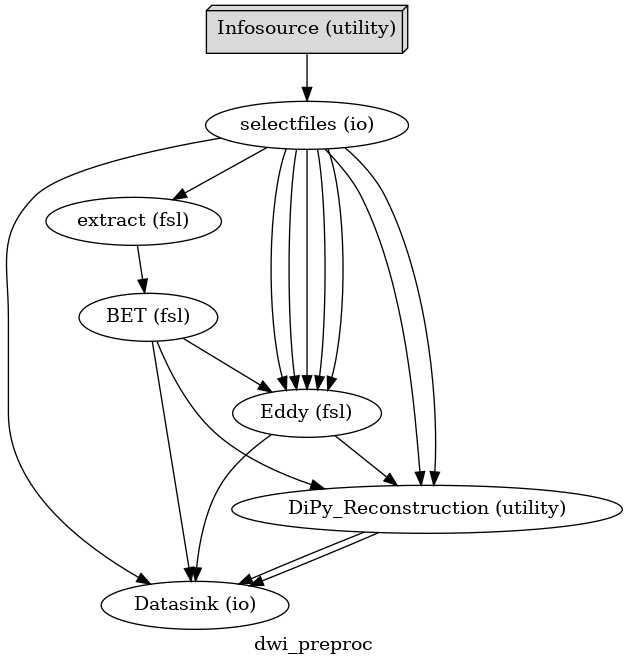

In [56]:
# Create the workflow graph
dwi_preproc.write_graph("workflow_graph.dot")

# Display
Image(filename=opj(dwi_preproc.base_dir, 'dwi_preproc', 'workflow_graph.png'))

/c/Users/ducda/Documents/Brainhack2020/johnaldmcfist-neonatalNiPype


## Turn this workflow into an interactive Sankey Diagram

In [ ]:
nipype_dot = opj(dwi_preproc.base_dir, 'dwi_preproc', 'workflow_graph.dot')
with open(nipype_dot) as fhandle:
  graph_data = fhandle.readlines()
sources = []
targets = []
for line in graph_data:
  if "->" in line:
    tmpnodes = line.split(" -> ")
    sources.append(tmpnodes[0].replace('  ',''))
    targets.append(tmpnodes[1].replace(';\n',''))

nodelist = list(sources + targets)
nodelist = list(dict.fromkeys(nodelist))
sankey_index = list(range(0, len(nodelist)))
nodedict = dict(zip(nodelist, sankey_index))
valuelist = list('1' * len(sources))
sourcelist = [nodedict.get(n, n) for n in sources]
targetlist = [nodedict.get(n, n) for n in targets]

In [89]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = nodelist,
      color = "blue"
    ),
    link = dict(
      source = sourcelist, # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = targetlist,
      value = valuelist, 
  ))])

fig.update_layout(title_text="Example Preprocessing Worflow", font_size=10)
fig.show()

## Run the Workflow

In [58]:
dwi_preproc.run()

200604-13:50:26,230 nipype.workflow INFO:
	 Workflow dwi_preproc settings: ['check', 'execution', 'logging', 'monitoring']
200604-13:50:26,327 nipype.workflow INFO:
	 Running serially.
200604-13:50:26,328 nipype.workflow INFO:
	 [Node] Setting-up "dwi_preproc.selectfiles" in "/c/Users/ducda/Documents/Brainhack2020/johnaldmcfist-neonatalNiPype/output/workingdir/dwi_preproc/_subject_id_6001/selectfiles".
200604-13:50:26,346 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
200604-13:50:26,373 nipype.workflow INFO:
	 [Node] Finished "dwi_preproc.selectfiles".
200604-13:50:26,374 nipype.workflow INFO:
	 [Node] Setting-up "dwi_preproc.extract" in "/c/Users/ducda/Documents/Brainhack2020/johnaldmcfist-neonatalNiPype/output/workingdir/dwi_preproc/_subject_id_6001/extract".
200604-13:50:26,400 nipype.workflow INFO:
	 [Node] Running "extract" ("nipype.interfaces.fsl.utils.ExtractROI"), a CommandLine Interface with command:
fslroi /c/Users/ducda/Documents/d

RuntimeError: Workflow did not execute cleanly. Check log for details

In [91]:
from nipype.utils.filemanip import loadpkl
res = loadpkl('/brainhack/crash-20200603-174016-neuro-Eddy.a0-755199eb-a315-4919-bf51-3fd6ed4807b2.pklz')
res

{'node': dwi_preproc.Eddy.a0,
 'traceback': ['Traceback (most recent call last):\n',
  '  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/linear.py", line 46, in run\n    node.run(updatehash=updatehash)\n',
  '  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 516, in run\n    result = self._run_interface(execute=True)\n',
  '  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 635, in _run_interface\n    return self._run_command(execute)\n',
  '  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 741, in _run_command\n    result = self._interface.run(cwd=outdir)\n',
  '  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/interfaces/base/core.py", line 397, in run\n    runtime = self._run_interface(runtime)\n',
  '  File "/opt/miniconda-latest/envs/neuro/li

In [24]:
BIDSDataGrabber.output_spec

nipype.interfaces.base.specs.DynamicTraitedSpec

In [100]:
!eddy_openmp

/bin/sh: 1: eddy_openmp: not found


In [93]:
eddy.cmdline

AttributeError: 'Node' object has no attribute 'cmdline'